Download torch and torchvision

In [1]:
# pip install torch
# pip install timm

In [2]:
# pip install torchvision

Initialization

In [3]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from transformers import Dinov2Model, AutoImageProcessor
import matplotlib.pyplot as plt
import itertools
from copy import deepcopy

In [4]:
USE_GPU = True
dtype = torch.float32 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    device = torch.device('cpu')
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 4080 is available.


If the output is "using device: cpu": download CUDA toolkit (https://developer.nvidia.com/cuda-downloads)
https://pytorch.org/get-started/locally/

In [5]:
# data 
random_trans = [v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1)), 
                v2.RandomRotation(degrees=10)]

transform = v2.Compose([
                v2.ToImage(), 
                v2.ToDtype(torch.float32, scale=True),
                v2.RandomApply(random_trans, 0.15)
                # v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1)),
                # v2.RandomChannelPermutation(),
                # v2.Normalize((0.2382, 0.2426, 0.2483), (0.3126, 0.3170, 0.3241))
                ])

In [6]:
class CropButtonDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    # return classes
    def classes(self):
        return self.data.classes

In [7]:
# creat a dictionary that maps index to label
data_dir='ClassificationDataset_label/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [8]:
button_train = CropButtonDataset('ClassificationDataset_label/train', transform=transform)
loader_train = DataLoader(button_train, batch_size=64, shuffle=True)

button_val = CropButtonDataset('ClassificationDataset_label/val', transform=transform)
loader_val = DataLoader(button_val, batch_size=14, shuffle=True)

button_test = CropButtonDataset('ClassificationDataset_label/test', transform=transform)
loader_test = DataLoader(button_test, batch_size=14, shuffle=False)

Check If load correctly

In [9]:
loader_train

In [10]:
for images, labels in loader_val:
    print("Batch loaded!")
    print("Images shape:", images.shape)
    print("Labels:", labels)
    break


Batch loaded!
Images shape: torch.Size([14, 3, 320, 320])
Labels: tensor([0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0])


Model setup

In [ ]:
class Dinov2BinaryClassifier(nn.Module):
    def __init__(
        self,
        backbone_name: str = "facebook/dinov2-small",
        hidden_dim: int = 512,
        dropout_prob: float = 0.4,
    ):
        """
        Param:
            - backbone_name: Hugging Face Dinov2 
            - hidden_dim: hidden dim
            - dropout_prob: dropout ratio
        """
        super().__init__()
        # 1) data preprocessing (check next cell for deatils)
        self.processor = AutoImageProcessor.from_pretrained(backbone_name)

        # 2) load pretrained weight
        self.backbone = Dinov2Model.from_pretrained(backbone_name)

        # 3) Classification Head：CLS token -> hidden_dim -> ReLU -> Dropout
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.config.hidden_size, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, 1),  # BCE 1 dim output
        )

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        """
        Param:
            - pixel_values: shape = (batch_size, 3, image_size, image_size),
        Output:
            - logits: shape = (batch_size, 2) raw score
        """
        # 1) send input into Dinov2 backbone,get last_hidden_state
        #    outputs.last_hidden_state = (batch_size, seq_len, hidden_size)，
        #    seq_len = patch + 1（CLS token）
        outputs = self.backbone(pixel_values=pixel_values)
        last_hidden = outputs.last_hidden_state  # (B, seq_len, hidden)

        # 2) get CLS token：last_hidden[:, 0, :]
        cls_token = last_hidden[:, 0, :]  # (B, hidden_size)

        # 3) sends CLS toekn
        logits = self.classifier(cls_token)  # (B, 2)
        return logits

Check augmentation

In [12]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [13]:
# processor

test backbone

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model
model = Dinov2BinaryClassifier(
    backbone_name="facebook/dinov2-small",
    hidden_dim=512,
    dropout_prob=0.4,
).to(device)

dummy_images = torch.randn(2, 3, 224, 224).to(device)  # (B=2, C=3, H=224, W=224)

with torch.no_grad():
    logits = model(dummy_images)

print("Logits:", logits)
probs = torch.softmax(logits, dim=-1)
print("Probabilities:", probs)

Logits: tensor([[-0.5660],
        [ 0.3766]], device='cuda:0')
Probabilities: tensor([[1.],
        [1.]], device='cuda:0')


In [15]:
def check_accuracy_final(loader, model, out=False):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype).unsqueeze(1)
            scores = model(x)
            preds = (torch.sigmoid(scores) > 0.5).long()

            # print prediction
            if out:
                pred_probs = torch.sigmoid(scores).flatten().tolist()
                labels = y.flatten().tolist()

                pred_str = ', '.join([f"{p * 100:.1f}%" for p in pred_probs])
                label_str = ', '.join(map(str, labels))

                print(f"    Sample preds : [{pred_str}]")
                print(f"    Sample labels: [{label_str}]")
            
            num_correct += (preds == y.long()).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc

In [16]:
def train(model, optimizer, epochs=10):
    x1 = list(range(len(loader_train) * epochs))
    y1 = []
    y2 = []
    y3 = []
    model = model.to(device=device)
    criterion = nn.BCEWithLogitsLoss()
    cnt = 1
    total_cnt = epochs * len(loader_train)
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype).unsqueeze(1)

            scores = model(x)
            loss = criterion(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y1.append(loss.item())
            if (cnt % 2 == 0):
                acc_val = check_accuracy_final(loader_val, model, out=True)
            else:
                acc_val = check_accuracy_final(loader_val, model)
            acc_train = check_accuracy_final(loader_train, model, out=False)
            y2.append(acc_val)
            y3.append(check_accuracy_final(loader_train, model))
            print(f"Iter: {cnt}/{total_cnt:<5} |  Loss: {loss.item():<9.6f} |  Train Acc: {acc_train:<7.4f} |  Val Acc: {acc_val:<7.4f}")
            cnt += 1
    return (x1, y1, y2, y3)

def plotpic(data):
    x, y1, y2, y3 = data
    plt.figure()
    plt.plot(x, y1, marker='.')
    plt.xlabel('Iteratoin')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.grid(True)

    plt.figure()
    plt.plot(x, y2, marker='o', label='Validation Accuracy')
    plt.plot(x, y3, marker='o', label='Training Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

Find best hyperparameter

In [17]:
def hyperparameter_search(DinoClassifier, loader_train, loader_val, device, epochs=3, opt=False):
    lr_list = 10 ** np.random.uniform(-2, -6, (10,))
    wd_list = 10 ** np.random.uniform(-2, -4, (5,))
    beta_list = [(0.85, 0.99), (0.85, 0.995), (0.9, 0.98), (0.9, 0.99), (0.9, 0.995), (0.9, 0.999),
    (0.95, 0.98), (0.95, 0.99), (0.95, 0.995), (0.95, 0.999)]

    best_acc = 0.0
    best_model = None
    best_params = {}
    
    for lr, wd, betas in itertools.product(lr_list, wd_list, beta_list):
        print(f"\n🔧 Testing AdamW: lr={lr}, wd={wd}, betas={betas}")
        
        model = DinoClassifier().to(device)
        optimizer = torch.optim.AdamW(
            [
                {"params": model.dinov2.parameters(), "lr": lr / 10},            
                {"params": model.classifier.parameters(), "lr": lr * 10},    
            ],
            weight_decay=wd,
            betas=betas
        )

        data = train(model, optimizer, epochs=epochs, opt=opt)
        _, _, val_accs, _ = data

        final_val_acc = val_accs[-1]
        print(f"Final val acc for lr={lr}, wd={wd}: {final_val_acc:.4f}")

        if final_val_acc > best_acc:
            best_acc = final_val_acc
            best_params = {"lr": lr, "weight_decay": wd}
            best_model = deepcopy(model)
            best_training_data = data

    print("\n Best Hyperparameters:")
    print(best_params)
    print(f"Best val acc: {best_acc:.4f}")

    # save model
    torch.save(best_model.state_dict(), "best_dino_model.pt")
    print(" Saved best model to best_dino_model.pt")

    return best_model, best_params, best_training_data


In [18]:
# best_model, best_params, best_training_data = hyperparameter_search(Dinov2BinaryClassifier, loader_train, loader_val, device, opt=False)

In [19]:
# check_accuracy_final(loader_test, best_model, True)

Train best model

In [20]:
final_model = Dinov2BinaryClassifier(hidden_dim=256, dropout_prob=0.4)

In [21]:
from torchinfo import summary
summary(final_model, input_size=(1, 3, 320, 320))

Layer (type:depth-idx)                                       Output Shape              Param #
Dinov2BinaryClassifier                                       [1, 1]                    --
├─Dinov2Model: 1-1                                           [1, 384]                  --
│    └─Dinov2Embeddings: 2-1                                 [1, 485, 384]             526,848
│    │    └─Dinov2PatchEmbeddings: 3-1                       [1, 484, 384]             226,176
│    │    └─Dropout: 3-2                                     [1, 485, 384]             --
│    └─Dinov2Encoder: 2-2                                    [1, 485, 384]             --
│    │    └─ModuleList: 3-3                                  --                        21,302,784
│    └─LayerNorm: 2-3                                        [1, 485, 384]             768
├─Sequential: 1-2                                            [1, 1]                    --
│    └─Linear: 2-4                                           [1, 256]       

In [22]:
# hard code best paramm
lr = 6.839252303713852e-06
wd= 0.00011822143451838108
beta = (0.9, 0.998)

In [23]:
optimizer = torch.optim.AdamW(
            [
                {"params": final_model.backbone.parameters(), "lr": lr / 10},
                {"params": final_model.classifier.parameters(), "lr": lr * 10},
            ],
            weight_decay=wd,
            betas= beta
        )
data = train(final_model, optimizer, epochs=50)

Iter: 1/100   |  Loss: 0.694445  |  Train Acc: 0.4272  |  Val Acc: 0.6429 
    Sample preds : [46.0%, 56.9%, 55.7%, 48.9%, 52.8%, 53.5%, 49.5%, 55.8%, 42.5%, 50.6%, 47.0%, 42.9%, 58.8%, 58.2%]
    Sample labels: [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]
Iter: 2/100   |  Loss: 0.769412  |  Train Acc: 0.5340  |  Val Acc: 0.6429 
Iter: 3/100   |  Loss: 0.688455  |  Train Acc: 0.5340  |  Val Acc: 0.4286 
    Sample preds : [43.3%, 38.2%, 45.8%, 47.4%, 41.4%, 42.7%, 38.2%, 52.1%, 45.8%, 54.6%, 43.2%, 54.3%, 47.4%, 39.7%]
    Sample labels: [1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]
Iter: 4/100   |  Loss: 0.696395  |  Train Acc: 0.5825  |  Val Acc: 0.5714 
Iter: 5/100   |  Loss: 0.724850  |  Train Acc: 0.6019  |  Val Acc: 0.5000 
    Sample preds : [39.8%, 36.7%, 51.5%, 46.6%, 40.6%, 36.8%, 39.6%, 41.1%, 50.1%, 44.8%, 48.7%, 43.0%, 42.3%, 44.2%]
    Sample labels: [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
I

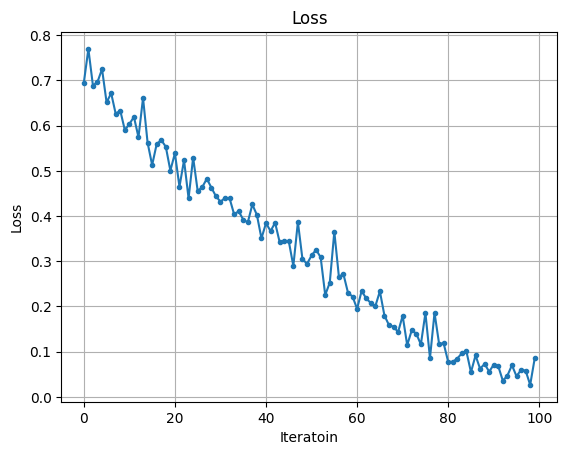

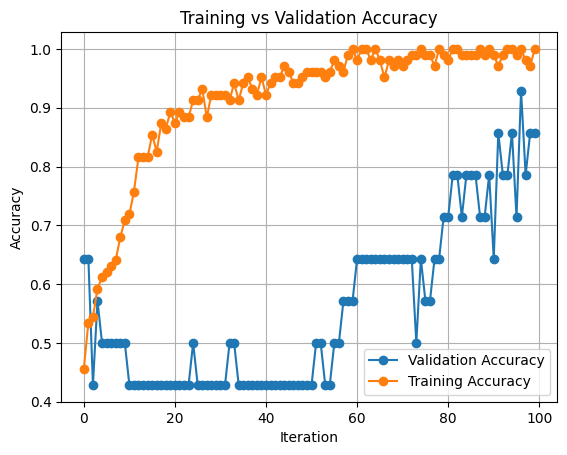

In [28]:
plotpic(data)

In [29]:
check_accuracy_final(loader_test, final_model,out=True)

    Sample preds : [32.4%, 12.5%, 2.8%, 2.1%, 20.8%, 77.6%, 7.2%, 19.2%, 4.6%, 32.2%, 98.1%, 55.6%, 88.6%, 99.5%]
    Sample labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


0.7142857142857143

In [30]:
def show_predictions_grid(loader, model, class_names=None, max_images=12, images_per_row=3):
    model.eval()
    images_shown = 0

    all_imgs = []
    all_titles = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            probs = torch.sigmoid(scores)
            preds = (probs > 0.5).long().squeeze(1)

            for i in range(x.size(0)):
                if images_shown >= max_images:
                    break

                img = x[i].cpu()
                np_img = img.permute(1, 2, 0).numpy()

                pred_label = preds[i].item()
                true_label = y[i].item()
                pred_text = class_names[pred_label] if class_names else str(pred_label)
                true_text = class_names[true_label] if class_names else str(true_label)
                title = f"Pred: {pred_text} / GT: {true_text}"

                all_imgs.append(np_img)
                all_titles.append(title)
                images_shown += 1
            if images_shown >= max_images:
                break

    num_cols = images_per_row
    num_rows = (len(all_imgs) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))

    for i, ax in enumerate(axes.flat):
        if i < len(all_imgs):
            ax.imshow(all_imgs[i])
            ax.set_title(all_titles[i], fontsize=10)
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

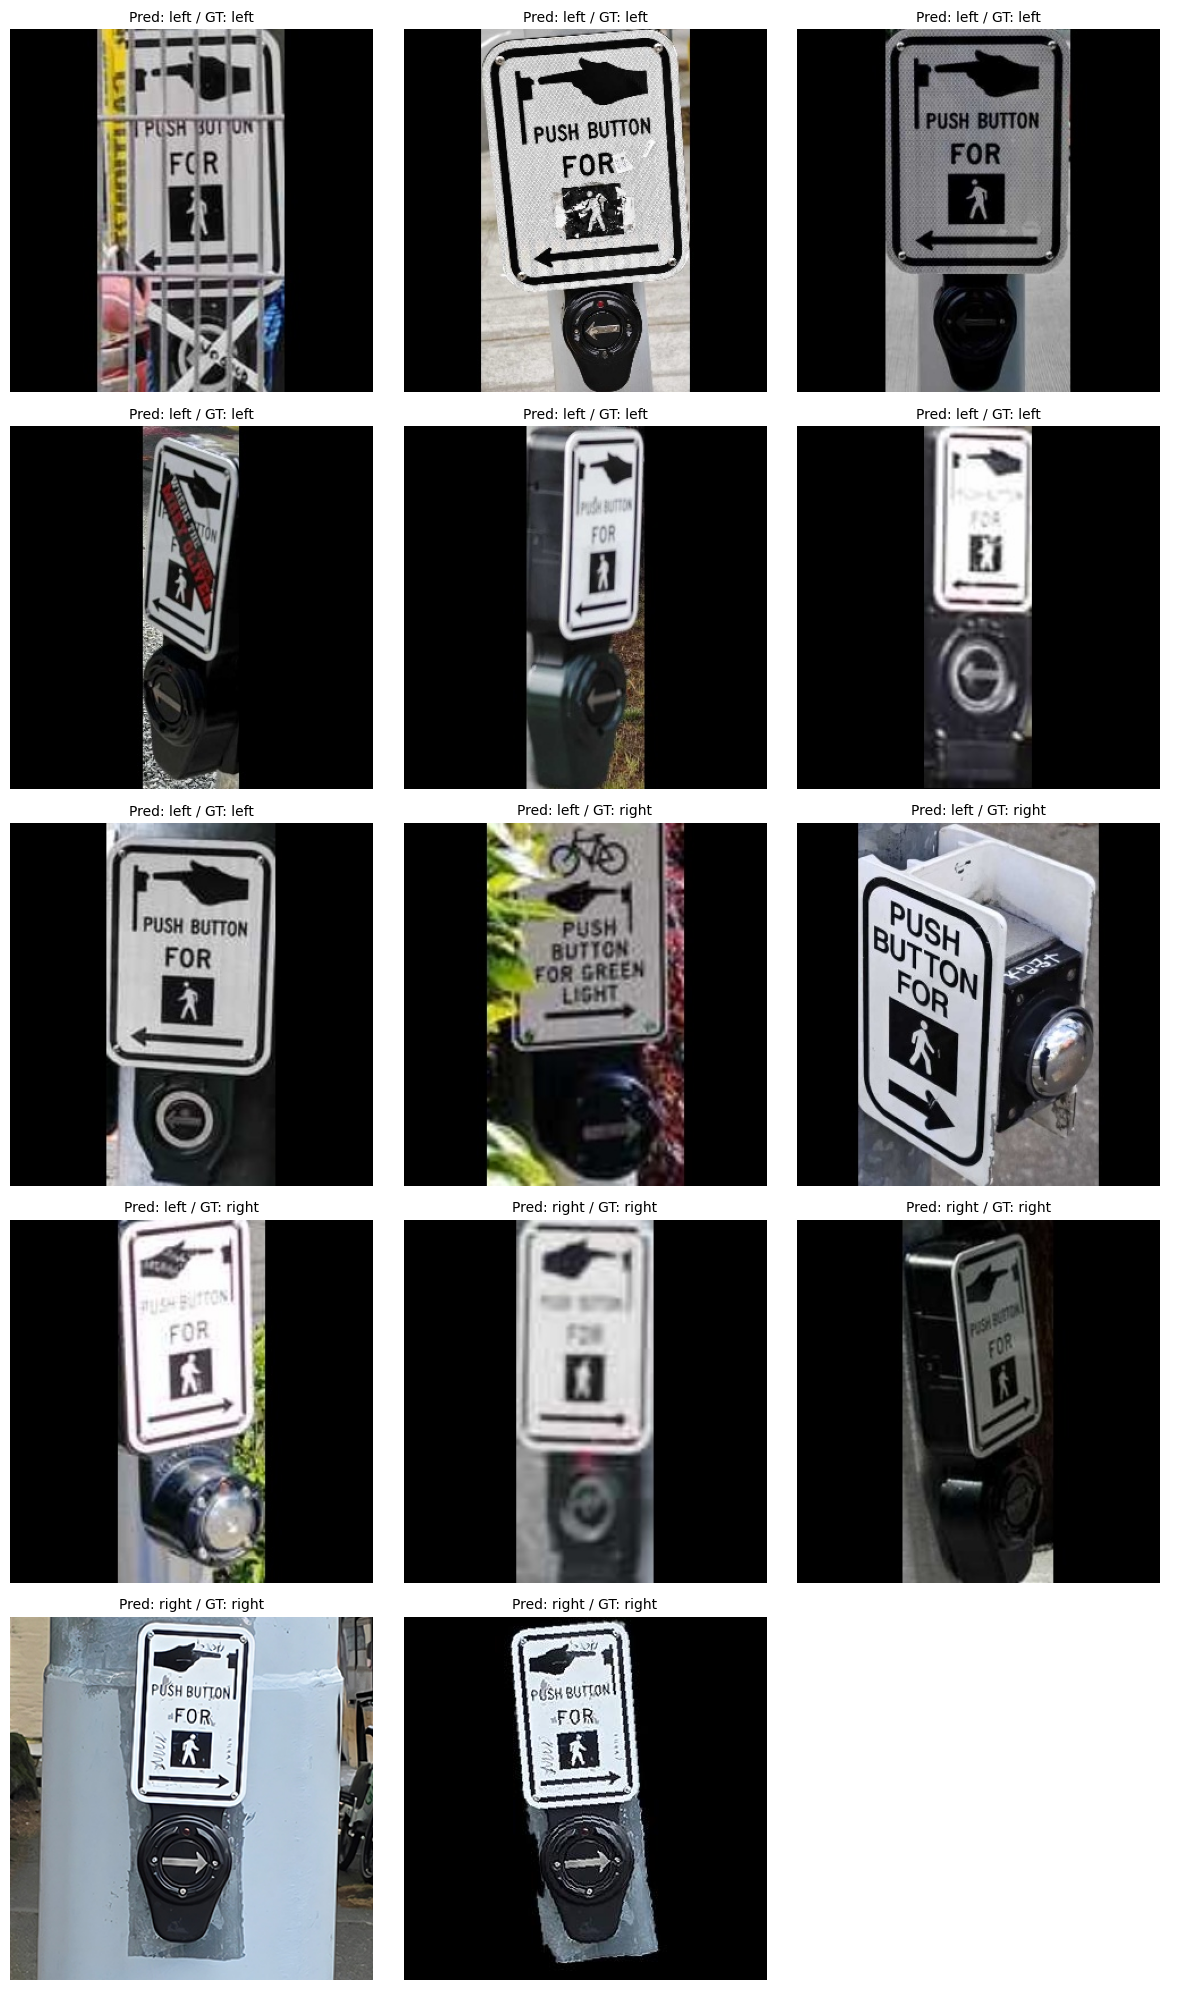

In [31]:
show_predictions_grid(loader_test, final_model, class_names=['left', 'right'], max_images=14, images_per_row=3)

Save model

In [32]:
torch.save(final_model.state_dict(), "dinov2_small_weights.pth")

Check Grad-Cam

In [ ]:
model = Dinov2BinaryClassifier(hidden_dim=256, dropout_prob=0.4)  
model.load_state_dict(torch.load("dinov2_small_256_.4.pth"))
model.eval()

Dinov2BinaryClassifier(
  (backbone): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2LayerSca

In [ ]:
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

# # Step 1: 准备模型
# model = final_model.eval().to(device)

# # Step 2: 指定你要 hook 的层（比如 DINOv2 的最后一个 Transformer Block）
# target_layers = [model.backbone.encoder.layer[-1]]  # 你要确认这个存在！

# # Step 3: 加载图像并预处理
# img = Image.open("your_image.jpg").convert("RGB")

# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
# ])
# input_tensor = transform(img).unsqueeze(0).to(device)

# # 可视化时要还原图像
# rgb_img = np.array(img.resize((224, 224))).astype(np.float32) / 255.0

# # Step 4: 构造目标类别
# targets = [ClassifierOutputTarget(1)]  # 二分类中预测 "right"

# # Step 5: 使用 GradCAM
# with GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as cam:
#     grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
#     grayscale_cam = grayscale_cam[0]  # 取 batch 的第一个图像

# # Step 6: 渲染 CAM
# visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# # Step 7: 显示
# plt.imshow(visualization)
# plt.axis("off")
# plt.title("Grad-CAM Visualization")
# plt.show()


SyntaxError: invalid syntax (2805178922.py, line 8)